In [1]:
import sys 
import os

In [2]:
src_path = os.path.abspath("../")
if src_path not in sys.path:
    sys.path.append(src_path)

In [3]:
from src.tools.md_class_functions import *
from src.tools.md_class_utility import*
from src.tools.md_class_graphs import *
from src.water_md_class import *

### Set path to your lammps file and initialise trajectory object

In [ ]:
# path towards an ion trajectory with recombination happening
water_path = "../testing/recombination_tester.lammpstrj"

In [ ]:
 #initialise trajectory object by passing path, format and scaling = 0 means not scaled -> will be scaled in __init__
trj = Trajectory(water_path, format="lammpstrj", scaled=0, verbosity="silent")

### Access class atributes of the Trajectory object 

In [ ]:
    # access class atributes which are calculated on initialisation, basic information about the trajectory 
    print("Trajectory first 3 rows")
    print(trj.trajectory[0, :3, :])
    print("box dimensions")
    print(trj.box_dim[0])
    print("box size")
    print(trj.box_size[0])
    print("number of atoms")
    print(trj.n_atoms)
    print("number of timesteps")
    print(trj.n_snapshots)
    print("species split")
    print("s1 = Hydrogen")
    print(trj.s1[0][:3, :])
    print("s2 = Oxygen")
    print(trj.s2[0][:3, :])
    print("did recombine?")
    print(trj.did_recombine)
    print("Recombination Time")
    print(trj.recombination_time)

### Class Methods


In [ ]:
#sets the self.distance attribute
trj.get_ion_distance()

In [ ]:
plot_ion_distance_euc(trj, (11, 6))

In [ ]:
#for further evaluations i just pick one timestep < recombination_time
time_step = 773

In [ ]:
bonding_list, unique_oxygens, ions = trj.get_hydrogen_bonds(timestep=time_step, cutoff=2.9, starting_oh=True)

In [ ]:
plot_hbonds_single(bonding_list, trj.s2[time_step], start="OH", fig_size=(10, 8))

In [ ]:
bonds_H3O, oxygens_H3O, ions =  trj.get_hydrogen_bonds(timestep=time_step, cutoff=2.9, starting_oh=False)
bonds_OH, oxygens_OH, _ =  trj.get_hydrogen_bonds(timestep=time_step, cutoff=2.9, starting_oh=True)

In [ ]:
plot_hbond_network(bonds_OH, bonds_H3O, trj.s2[time_step], ions, fig_size=(10, 8))

In [ ]:
# HB bonds for the entire trajectory
hb_timeseries = get_HB_timeseries(trj)

In [ ]:
# use %matplotlib widget or similar to make interactive
plot_HB_network(hb_timeseries, trj.s2, plot_oxygen=True)

In [ ]:
plot_HB_ratio(hb_timeseries, n_atoms=trj.n_atoms)

In [18]:
wire_lengths, h_bonds = get_all_wires(trj)

In [20]:
%matplotlib widget

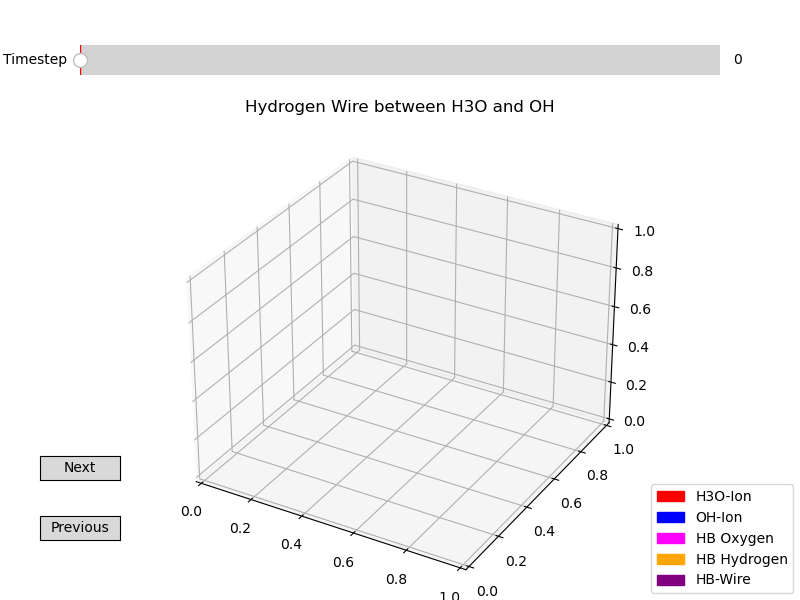

In [25]:
plot_HB_wire(h_bonds, trj, plot_hydrogens=True)

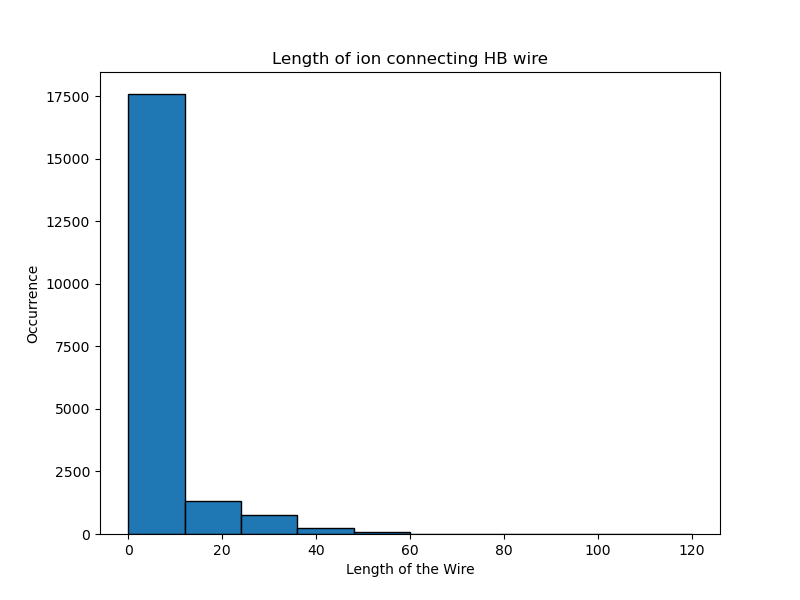

In [26]:
plot_wire_length(wire_lengths)

In [ ]:
ts_bonds, mol_list, ion_ts = get_transition_cations(trj)

In [ ]:
plot_transition_cations(mol_list, ion_ts, trj)

In [ ]:
OO_rdf = trj.get_rdf_rdist(stop=8.0)

In [ ]:
OO_rdf

In [ ]:
HH_rdf = trj.get_rdf_rdist(gr_type="HH")

In [ ]:
plot_rdf(OO_rdf[0], OO_rdf[1])

In [ ]:
plot_rdf(HH_rdf[0], HH_rdf[1], type="HH")

In [ ]:
MSD = trj.get_MSD()

In [ ]:
plot_MSD(MSD)

In [ ]:
diff = trj.get_translational_diffusion(MSD)
diff

### Trajectory Manipulation




In [ ]:
#trjwater.lammpstrj is just a water sim trajectory without ions 
#note: (actually already has ions in it but they dont recombine still same concept)
path_water = "../testing/trjwater.lammpstrj"

In [ ]:
traj_2 = Trajectory(file=path_water, format="lammpstrj", scaled=1, verbosity="loud")

In [ ]:
# generate ion trajectories for ion MD runs
traj_2.get_displace(snapshot=50, distance=0.4, eps=0.05, path="../tutorial_notebook/", num_traj=2)

In [ ]:
#cut out trajectory at timestamp 50
traj_2.cut_snapshot(snapshot=50, path="../tutorial_notebook/")

In [ ]:
# remove 20 atoms from timestap 50
traj_2.remove_atoms(N=20, snap=50, format_out="lammps")

In [ ]:
# group together the molecules and writes it into a ovito readable lammpstrj file
traj_2.group_molecules(path="../tutorial_notebook/")

In [ ]:
data = np.loadtxt("C:\\Users\\Nutzer\\Documents\\GitHub\\MD_Lammps_analysis_class\\tutorial_notebook\\OH_ion_RDF_averaged.csv", delimiter=",")
plt.plot(data[1], data[0])

In [ ]:
data = np.loadtxt("C:\\Users\\Nutzer\\Documents\\GitHub\\MD_Lammps_analysis_class\\tutorial_notebook\\H3O_ion_RDF_averaged.csv", delimiter=",")
plt.plot(data[1], data[0])

In [ ]:
h3o_ids_ts = np.empty((trj.recombination_time, ), dtype=int)
oh_ids_ts = np.empty((trj.recombination_time, ), dtype=int)
for ts in range(trj.recombination_time):
    
    OH_id = None
    H3O_id = None

    # note: find nearest O atom for each H atom
    indexlist_group, _ = trj.get_neighbour_KDT(species_1=trj.s1[ts],
                                                species_2=trj.s2[ts], mode="pbc", snapshot=ts)

    # note: find he  number of  occourence of O atoms for which it is the nearest to an H atom.
    # -> for H2O each O atom will count twice, for each H3O+ each O atom will count 3 times and so on.
    temp = [None] * trj.s2[ts].shape[0]
    for O_atom in range(trj.s2[ts].shape[0]):
        temp[O_atom] = np.append(np.argwhere(indexlist_group == O_atom), O_atom)

    # check how often each O atom counted -> molecules formation  OH- = 1 time H3O+  3 Times  H2O 2 times.
    for ind, _list in enumerate(temp):
        if len(_list) == 2:
            OH_id = _list[-1]
        if len(_list) == 4:
            H3O_id = _list[-1]
            
    h3o_ids_ts[ts] = trj.s2[ts][H3O_id, 0]
    oh_ids_ts[ts] = trj.s2[ts][OH_id, 0]


jumps = []
diffusion = []
for position_id in range(1, trj.recombination_time):
    if h3o_ids_ts[position_id-1] != h3o_ids_ts[position_id]:
        jumps.append(position_id-1)
    else:
        diffusion.append(position_id-1)
        
        

    


In [ ]:
h3o_ids_ts

In [ ]:
jumps

In [ ]:
diffusion

In [ ]:
def get_diffusion_distance(jumps: [int], diffusion: [int], ion_ids: [int], trj: Trajectory):
    
    coordinates = trj.s2
    temp = []
    diffusion_distances = []

    previous = diffusion[0]
    intervalls = []
    _temp = []


    for diff_ts in range(1, len(diffusion)):
        #print(previous)
        if (diffusion[diff_ts] - 1 == previous): 
            _temp.append(previous)
            previous = diffusion[diff_ts]
        else:
            _temp.append(previous)
            if len(_temp) > 1:
                intervalls.append(_temp)
            _temp = []
            previous = diffusion[diff_ts]
    print(intervalls)
    for diffusion_int in intervalls:
        for diff in range(len(diffusion_int) -1):
            temp.append(get_distance(coordinates[diffusion_int[diff]][coordinates[diffusion_int[diff]][:, 0]==ion_ids[diffusion_int[diff]], 2:][0],
                                    coordinates[diffusion_int[diff+1]][coordinates[diffusion_int[diff+1]][:, 0]==ion_ids[diffusion_int[diff+1]], 2:][0],
                                    mode="pbc"))
        diffusion_distances.append(sum(temp))
        temp = []
    return diffusion_distances
        

In [ ]:
def get_jump_distances(jumps: [int], ion_ids: [int], trj: Trajectory):
    
    coordinates = trj.s2
    jump_distances = []
    
    for jump_ts in range(len(jumps)):
        jump_distances.append(get_distance(coordinates[jumps[jump_ts]][coordinates[jumps[jump_ts]][:, 0] == ion_ids[jumps[jump_ts]], 2:][0],
                                          coordinates[jumps[jump_ts]-1][coordinates[jumps[jump_ts]-1][:, 0] == ion_ids[jumps[jump_ts]-1], 2:][0],
                                          mode="pbc"))
        
    return jump_distances

In [ ]:
diff_dist = get_diffusion_distance(jumps, diffusion, h3o_ids_ts, trj)
jump_dist = get_jump_distances(jumps, h3o_ids_ts, trj)

In [ ]:
jump_dist

In [ ]:
diff_dist

In [1]:
import struct
print(struct.calcsize("P") * 8)

32


In [4]:
path = "Z://cluster_runs//n_608//NN_charged_test//results//neutral_system//neutral_run_0//trjwater.lammpstrj"

In [5]:
trj = Trajectory(file=path)

In [7]:
trj.did_recombine

False

In [9]:
diffusion, jumps, h3_ids_ts = diffusion_timestep_tracing(trj)

In [11]:
diff_dist = get_diffusion_distance(diffusion, h3_ids_ts, trj)

[[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], [25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46], [48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74], [76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121], [123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165], [167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184], [186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224

In [12]:
jump_dist = get_jump_distances(jumps, h3_ids_ts, trj)

In [14]:
len(jump_dist)

101

In [15]:
len(diff_dist)

101

In [16]:

def autocorrelation_function(distances):
    """
    Calculate the autocorrelation function of a list of distances.
    
    Parameters:
    distances (list or np.ndarray): List or array of distance values (diffusion or jump distances).
    
    Returns:
    np.ndarray: Autocorrelation function for the input distance list.
    """
    distances = np.array(distances)
    N = len(distances)
    mean_distance = np.mean(distances)
    
    acf = np.zeros(N)
    
    for tau in range(N):
        acf[tau] = np.mean((distances[:N - tau] - mean_distance) * (distances[tau:] - mean_distance))
    
    return acf / acf[0]  # Normalize by the value at tau=0 (to get a normalized ACF)


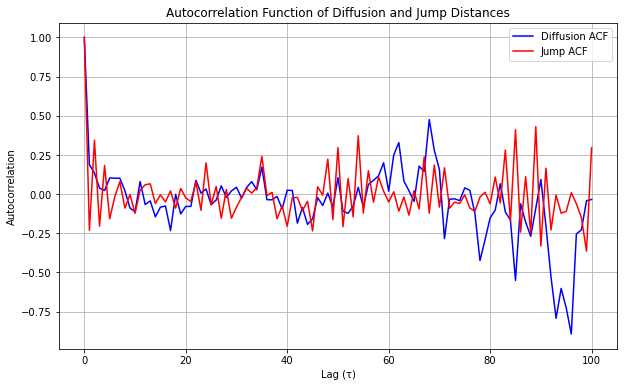

In [17]:
# Compute autocorrelation functions
acf_diffusion = autocorrelation_function(jump_dist)
acf_jump = autocorrelation_function(diff_dist)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(acf_diffusion, label='Diffusion ACF', color='blue')
plt.plot(acf_jump, label='Jump ACF', color='red')
plt.xlabel('Lag (τ)')
plt.ylabel('Autocorrelation')
plt.legend()
plt.title('Autocorrelation Function of Diffusion and Jump Distances')
plt.grid(True)
plt.show()

ValueError: URLs are not writeable